In [1]:
import argparse
import json
import os
import re
from collections import defaultdict
import sys

import numpy
import random
import torch
from datasets import load_dataset
from matplotlib import pyplot as plt
from tqdm import tqdm
from transformers import AutoModelForCausalLM, AutoTokenizer

from dsets import KnownsDataset
from rome.tok_dataset import (
    TokenizedDataset,
    dict_to_,
    flatten_masked_batch,
    length_collation,
)
from util import nethook
from util.globals import DATA_DIR
from util.runningstats import Covariance, tally

display_modelname = 'phi'

def trace_with_patch(
    model,  # The model
    inp,  # A set of inputs
    states_to_patch,  # A list of (token index, layername) triples to restore
    answers_t,  # Answer probabilities to collect
    tokens_to_mix,  # Range of tokens to corrupt (begin, end)
    noise=0.1,  # Level of noise to add
    trace_layers=None,  # List of traced outputs to return
):
    prng = numpy.random.RandomState(1)  # For reproducibility, use pseudorandom noise
    patch_spec = defaultdict(list)
    for t, l in states_to_patch:
        patch_spec[l].append(t)
    embed_layername = layername(model, 0, "embed")

    def untuple(x):
        return x[0] if isinstance(x, tuple) else x

    # Define the model-patching rule.
    def patch_rep(x, layer):
        if layer == embed_layername:
            # If requested, we corrupt a range of token embeddings on batch items x[1:]
            if tokens_to_mix is not None:
                b, e = tokens_to_mix
                x[1:, b:e] += noise * torch.from_numpy(
                    prng.randn(x.shape[0] - 1, e - b, x.shape[2])
                ).to(x.device)
            return x
        if layer not in patch_spec:
            return x
        # If this layer is in the patch_spec, restore the uncorrupted hidden state
        # for selected tokens.
        h = untuple(x)
        for t in patch_spec[layer]:
            h[1:, t] = h[0, t]
        return x

    # With the patching rules defined, run the patched model in inference.
    additional_layers = [] if trace_layers is None else trace_layers
    with torch.no_grad(), nethook.TraceDict(
        model,
        [embed_layername] + list(patch_spec.keys()) + additional_layers,
        edit_output=patch_rep,
    ) as td:
        outputs_exp = model(**inp)

    # We report softmax probabilities for the answers_t token predictions of interest.
    probs = torch.softmax(outputs_exp.logits[1:, -1, :], dim=1).mean(dim=0)[answers_t]

    # If tracing all layers, collect all activations together to return.
    if trace_layers is not None:
        all_traced = torch.stack(
            [untuple(td[layer].output).detach().cpu() for layer in trace_layers], dim=2
        )
        return probs, all_traced

    return probs

def get_score(mt, prompt, subject, samples=10, noise=0.1, window=10):
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    vanilla_inp = make_inputs(mt.tokenizer, [prompt])
    output_tok, high_score = predict_from_input(mt.model, vanilla_inp)
    return high_score.item(), low_score

def calculate_hidden_flow(
    mt, prompt, subject, samples=10, noise=0.1, window=10, kind=None,
    token_range=None
):
    """
    Runs causal tracing over every token/layer combination in the network
    and returns a dictionary numerically summarizing the results.
    """
    inp = make_inputs(mt.tokenizer, [prompt] * (samples + 1))
    with torch.no_grad():
        answer_t, base_score = [d[0] for d in predict_from_input(mt.model, inp)]
    [answer] = decode_tokens(mt.tokenizer, [answer_t])
    e_range = find_token_range(mt.tokenizer, inp["input_ids"][0], subject)
    low_score = trace_with_patch(
        mt.model, inp, [], answer_t, e_range, noise=noise
    ).item()
    if not kind:
        differences = trace_important_states(
            mt.model, mt.num_layers, inp, e_range, answer_t, noise=noise, token_range=token_range
        )
    else:
        differences = trace_important_window(
            mt.model,
            mt.num_layers,
            inp,
            e_range,
            answer_t,
            noise=noise,
            window=window,
            kind=kind,
            token_range=token_range
        )
    differences = differences.detach().cpu()
    return dict(
        scores=differences,
        low_score=low_score,
        high_score=base_score,
        input_ids=inp["input_ids"][0],
        input_tokens=decode_tokens(mt.tokenizer, inp["input_ids"][0]),
        subject_range=e_range,
        answer=answer,
        window=window,
        kind=kind or "",
    )


def trace_important_states(model, num_layers, inp, e_range, answer_t, noise=0.1, token_range=None):
    ntoks = inp["input_ids"].shape[1]
    # print(num_layers, inp, e_range, answer_t, noise, token_range)
    table = []
    subject_start, subject_end = e_range
    for tnum in range(subject_end, ntoks):
        row = []
        for layer in range(num_layers):
            if tnum>=subject_end:
                r = trace_with_patch(
                    model,
                    inp,
                    [(tnum, layername(model, layer))],
                    answer_t,
                    tokens_to_mix=e_range,
                    noise=noise,
                )
                # print(f"appending {r}")
                row.append(r)
            else:
                row.append(torch.tensor(0.0).to(device="cuda:0"))
            # print(f"The row is {row}")
        table.append(torch.stack(row))
    return torch.stack(table)


def trace_important_window(
    model, num_layers, inp, e_range, answer_t, kind, window=10, noise=0.1, token_range=None,
):
    
    ntoks = inp["input_ids"].shape[1]
    table = []
    subject_start, subject_end = e_range
    for tnum in range(subject_end, ntoks):
        row = []
        for layer in range(num_layers):
            layerlist = [
                (tnum, layername(model, L, kind))
                for L in range(
                    max(0, layer - window // 2), min(num_layers, layer - (-window // 2))
                )
            ]
            if tnum>=subject_end:
                r = trace_with_patch(
                    model, inp, layerlist, answer_t, tokens_to_mix=e_range, noise=noise
                )
                row.append(r)
            else:
                row.append(torch.tensor(0.0).to(device="cuda:0"))
        table.append(torch.stack(row))
    return torch.stack(table)


class ModelAndTokenizer:
    """
    An object to hold on to (or automatically download and hold)
    a GPT-style language model and tokenizer.  Counts the number
    of layers.
    """

    def __init__(
        self,
        model_name=None,
        model=None,
        tokenizer=None,
        low_cpu_mem_usage=False,
        torch_dtype=None,
    ):
        if tokenizer is None:
            assert model_name is not None
            tokenizer = AutoTokenizer.from_pretrained(model_name)
        if model is None:
            assert model_name is not None
            model = AutoModelForCausalLM.from_pretrained(
                model_name, low_cpu_mem_usage=low_cpu_mem_usage, torch_dtype=torch_dtype,
                cache_dir="/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/.cache/"
            )
            nethook.set_requires_grad(False, model)
            model.eval().cuda()
        self.tokenizer = tokenizer
        self.model = model
        self.layer_names = [
            n
            for n, m in model.named_modules()
            if (re.match(r"^(transformer|gpt_neox|model)\.(h|layers)\.\d+$", n))
        ]
        self.num_layers = len(self.layer_names)

    def __repr__(self):
        return (
            f"ModelAndTokenizer(model: {type(self.model).__name__} "
            f"[{self.num_layers} layers], "
            f"tokenizer: {type(self.tokenizer).__name__})"
        )


def layername(model, num, kind=None):
    if hasattr(model, "transformer"):
        if kind == "embed":
            return "transformer.wte"
        return f'transformer.h.{num}{"" if kind is None else "." + kind}'
    if hasattr(model, "gpt_neox"):
        if kind == "embed":
            return "gpt_neox.embed_in"
        if kind == "attn":
            kind = "attention"
        return f'gpt_neox.layers.{num}{"" if kind is None else "." + kind}'
    else:
        # assume it is llama/mistral
        if kind == "embed":
            return "model.embed_tokens"
        if kind == "attn":
            kind = "self_attn"
        return f'model.layers.{num}{"" if kind is None else "." + kind}'
    # assert False, "unknown transformer structure"


def guess_subject(prompt):
    return re.search(r"(?!Wh(o|at|ere|en|ich|y) )([A-Z]\S*)(\s[A-Z][a-z']*)*", prompt)[
        0
    ].strip()


def plot_hidden_flow(
    mt,
    prompt,
    subject=None,
    samples=10,
    noise=0.1,
    window=10,
    kind=None,
    savepdf=None,
):
    if subject is None:
        subject = guess_subject(prompt)
    result = calculate_hidden_flow(
        mt,
        prompt,
        subject,
        samples=samples,
        noise=noise,
        window=window,
        kind=kind,
    )
    plot_trace_heatmap(result, savepdf)


def plot_trace_heatmap(result, savepdf=None, title=None, xlabel=None, modelname=None):
    # print(result)
    differences = result["scores"]
    low_score = result["low_score"]
    answer = result["answer"]
    kind = (
        None
        if (not result["kind"] or result["kind"] == "None")
        else str(result["kind"])
    )
    window = result.get("window", 10)
    labels = list(result["input_tokens"])
    for i in range(*result["subject_range"]):
        labels[i] = labels[i] + "*"
    with plt.rc_context(rc={"font.family": "Times New Roman", "font.size": 4}):
        fig, ax = plt.subplots(figsize=(4, 2), dpi=200)
        h = ax.pcolor(
            differences,
            cmap={None: "Purples", "None": "Purples", "mlp": "Greens", "attn": "Reds"}[
                kind
            ],
            vmin=low_score,
        )
        ax.invert_yaxis()
        ax.set_yticks([0.5 + i for i in range(len(differences))])
        ax.set_xticks([0.5 + i for i in range(0, differences.shape[1] - 6, 5)])
        ax.set_xticklabels(list(range(0, differences.shape[1] - 6, 5)))
        ax.set_yticklabels(labels[-len(differences) :])
        if not modelname:
            modelname = "GPT"
        if not kind:
            ax.set_title("Impact of restoring state after corrupted input")
            ax.set_xlabel(f"single restored layer within {modelname}")
        else:
            kindname = "MLP" if kind == "mlp" else "Attn"
            ax.set_title(f"Impact of restoring {kindname} after corrupted input in {modelname}")
            ax.set_xlabel(f"center of interval of {window} restored {kindname} layers")
        cb = plt.colorbar(h)
        if title is not None:
            ax.set_title(title)
        if xlabel is not None:
            ax.set_xlabel(xlabel)
        elif answer is not None:
            # The following should be cb.ax.set_xlabel, but this is broken in matplotlib 3.5.1.
            cb.ax.set_title(f"p({str(answer).strip()})", y=-0.16, fontsize=5)
        if savepdf:
            os.makedirs(os.path.dirname(savepdf), exist_ok=True)
            plt.savefig(savepdf, bbox_inches="tight")
            plt.close()
        else:
            plt.show()

def plot_all_flow(mt, prompt, subject=None):
    for kind in ["mlp", "attn"]:
        plot_hidden_flow(mt, prompt, subject, kind=kind)


# Utilities for dealing with tokens
def make_inputs(tokenizer, prompts, device="cuda"):
    token_lists = [tokenizer.encode(p) for p in prompts]
    if token_lists == []:
        print(f"Buggy prompt: {prompts}")
    maxlen = max(len(t) for t in token_lists)
    if "[PAD]" in tokenizer.all_special_tokens:
        pad_id = tokenizer.all_special_ids[tokenizer.all_special_tokens.index("[PAD]")]
    else:
        pad_id = 0
    input_ids = [[pad_id] * (maxlen - len(t)) + t for t in token_lists]
    # position_ids = [[0] * (maxlen - len(t)) + list(range(len(t))) for t in token_lists]
    attention_mask = [[0] * (maxlen - len(t)) + [1] * len(t) for t in token_lists]
    return dict(
        input_ids=torch.tensor(input_ids).to(device),
        #    position_ids=torch.tensor(position_ids).to(device),
        attention_mask=torch.tensor(attention_mask).to(device),
    )


def decode_tokens(tokenizer, token_array):
    if hasattr(token_array, "shape") and len(token_array.shape) > 1:
        return [decode_tokens(tokenizer, row) for row in token_array]
    return [tokenizer.decode([t]) for t in token_array]

def find_token_range(tokenizer, token_array, substring):
    toks = decode_tokens(tokenizer, token_array)
    # print(f"Rahul the display modelname is {display_modelname}")
    if display_modelname != 'phi':
        whole_string = tokenizer.decode(token_array).replace(' ', '')
        sub = substring.replace(' ', '')
    else:
        whole_string = ''.join(toks)
        sub = substring.strip() 
    char_loc = whole_string.rindex(sub)
    loc = 0
    tok_start, tok_end = None, None
    all_spans = []
    cur=0
    for i, t in enumerate(toks):
        loc += len(t)
        if tok_start is None and loc > char_loc:
            tok_start = i
        if tok_end is None and loc >= char_loc + len(sub):
            tok_end = i + 1
            cur+=1
            return tok_start, tok_end

def predict_token(mt, prompts, return_p=False):
    inp = make_inputs(mt.tokenizer, prompts)
    preds, p = predict_from_input(mt.model, inp)
    result = [mt.tokenizer.decode(c) for c in preds]
    if return_p:
        result = (result, p)
    return result

def predict_topk(mt, prompts, k=5):
    inp = make_inputs(mt.tokenizer, prompts)
    indices, probs = predict_topk_logits(mt.model, inp, k=k)
    top_tokens = []
    for topk in indices:
        top_tokens.append([mt.tokenizer.decode(t) for t in topk])
    return top_tokens, probs


def predict_from_input(model, inp):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    p, preds = torch.max(probs, dim=1)
    return preds, p

def predict_topk_logits(model, inp, k=5):
    out = model(**inp)["logits"]
    probs = torch.softmax(out[:, -1], dim=1)
    values, indices = torch.topk(probs, k=k, dim=1)
    return indices, values.detach().cpu().numpy().tolist()
    


def collect_embedding_std(mt, subjects):
    alldata = []
    for s in subjects:
        inp = make_inputs(mt.tokenizer, [s])
        with nethook.Trace(mt.model, layername(mt.model, 0, "embed")) as t:
            mt.model(**inp)
            alldata.append(t.output[0])
    alldata = torch.cat(alldata)
    noise_level = alldata.std().item()
    return noise_level


def get_embedding_cov(mt):
    model = mt.model
    tokenizer = mt.tokenizer

    def get_ds():
        ds_name = "wikitext"
        raw_ds = load_dataset(
            ds_name,
            dict(wikitext="wikitext-103-raw-v1", wikipedia="20200501.en")[ds_name],
        )
        try:
            maxlen = model.config.n_positions
        except:
            maxlen = 100  # Hack due to missing setting in GPT2-NeoX.
        return TokenizedDataset(raw_ds["train"], tokenizer, maxlen=maxlen)

    ds = get_ds()
    sample_size = 1000
    batch_size = 5
    filename = None
    batch_tokens = 100

    progress = lambda x, **k: x

    stat = Covariance()
    loader = tally(
        stat,
        ds,
        cache=filename,
        sample_size=sample_size,
        batch_size=batch_size,
        collate_fn=length_collation(batch_tokens),
        pin_memory=True,
        random_sample=1,
        num_workers=0,
    )
    with torch.no_grad():
        for batch_group in loader:
            for batch in batch_group:
                batch = dict_to_(batch, "cuda")
                del batch["position_ids"]
                with nethook.Trace(model, layername(mt.model, 0, "embed")) as tr:
                    model(**batch)
                feats = flatten_masked_batch(tr.output, batch["attention_mask"])
                stat.add(feats.cpu().double())
    return stat.mean(), stat.covariance()


def make_generator_transform(mean=None, cov=None):
    d = len(mean) if mean is not None else len(cov)
    device = mean.device if mean is not None else cov.device
    layer = torch.nn.Linear(d, d, dtype=torch.double)
    nethook.set_requires_grad(False, layer)
    layer.to(device)
    layer.bias[...] = 0 if mean is None else mean
    if cov is None:
        layer.weight[...] = torch.eye(d).to(device)
    else:
        _, s, v = cov.svd()
        w = s.sqrt()[None, :] * v
        layer.weight[...] = w
    return layer


def collect_embedding_gaussian(mt):
    m, c = get_embedding_cov(mt)
    return make_generator_transform(m, c)


def collect_embedding_tdist(mt, degree=3):
    # We will sample sqrt(degree / u) * sample, where u is from the chi2[degree] dist.
    # And this will give us variance is (degree / degree - 2) * cov.
    # Therefore if we want to match the sample variance, we should
    # reduce cov by a factor of (degree - 2) / degree.
    # In other words we should be sampling sqrt(degree - 2 / u) * sample.
    u_sample = torch.from_numpy(
        numpy.random.RandomState(2).chisquare(df=degree, size=1000)
    )
    fixed_sample = ((degree - 2) / u_sample).sqrt()
    mvg = collect_embedding_gaussian(mt)

    def normal_to_student(x):
        gauss = mvg(x)
        size = gauss.shape[:-1].numel()
        factor = fixed_sample[:size].reshape(gauss.shape[:-1] + (1,))
        student = factor * gauss
        return student

    return normal_to_student

In [8]:
mt = ModelAndTokenizer("microsoft/phi-2")

knowns = KnownsDataset(known_loc='/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/repo-for-paper/attention-contributions-llama/datasets/RAG_data_with_object_at_0.json')  # Dataset of known facts

noise_level = "s3"
uniform_noise = False
if isinstance(noise_level, str):
    if noise_level.startswith("s"):
        # Automatic spherical gaussian
        factor = float(noise_level[1:]) if len(noise_level) > 1 else 1.0
        noise_level = factor * collect_embedding_std(
            mt, [k["subject"] for k in knowns]
        )
        print(f"Using noise_level {noise_level} to match model times {factor}")
    elif noise_level == "m":
        # Automatic multivariate gaussian
        noise_level = collect_embedding_gaussian(mt)
        print(f"Using multivariate gaussian to match model noise")
    elif noise_level.startswith("t"):
        # Automatic d-distribution with d degrees of freedom
        degrees = float(noise_level[1:])
        noise_level = collect_embedding_tdist(mt, degrees)
    elif noise_level.startswith("u"):
        uniform_noise = True
        noise_level = float(noise_level[1:])

random.Random(42).shuffle(knowns)
scores = []

for i,_ in tqdm(enumerate(knowns)):
    # print(f"Rahul: at index {i}")
    if i > 50:
        break
    known_id = knowns[i]["known_id"]
    random.shuffle(knowns[i]['context'])
    rag_context = '\n'.join(knowns[i]['context'])
    
    prefix = f"""USING CONTEXT ONLY AND NOT INTERNAL KNOWLEDGE, COMPLETE THE ANSWER. Context:\n {rag_context}\n Answer: """
    knowns[i]['prompt'] = prefix+knowns[i]['user_query']

    masking_span = prefix
    
    high, low = get_score(
        mt,
        knowns[i]["prompt"],
        masking_span,
        noise=noise_level                
    )
    print(high, low)
    scores.append((high, low))


Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Loaded dataset with 978 elements
Using noise_level 0.088691096752882 to match model times 3.0


1it [00:01,  1.21s/it]

0.8467361330986023 1.991750878005405e-06


2it [00:02,  1.20s/it]

0.9233982563018799 0.08526185899972916


3it [00:03,  1.25s/it]

0.9955139756202698 0.00011905135033885017


4it [00:04,  1.21s/it]

0.6672555804252625 0.016246676445007324


5it [00:06,  1.20s/it]

0.9640746116638184 0.32105064392089844


6it [00:07,  1.20s/it]

0.9767480492591858 0.03673586994409561


7it [00:08,  1.25s/it]

0.5865679979324341 0.04279530793428421


8it [00:09,  1.23s/it]

0.7720066905021667 0.0027021400164812803


9it [00:10,  1.22s/it]

0.9971508383750916 0.01261222641915083


10it [00:12,  1.18s/it]

0.833116888999939 0.007202466018497944


11it [00:13,  1.18s/it]

0.7375316619873047 0.00011809646821347997


12it [00:14,  1.22s/it]

0.6344130635261536 7.151112981773622e-07


13it [00:15,  1.20s/it]

0.57122403383255 0.03830721601843834


14it [00:16,  1.20s/it]

0.7283480763435364 5.966322714812122e-05


15it [00:18,  1.19s/it]

0.9687817096710205 0.031039157882332802


16it [00:19,  1.19s/it]

0.992501974105835 0.014789042063057423


17it [00:20,  1.19s/it]

0.9604940414428711 0.12889501452445984


18it [00:21,  1.24s/it]

0.9588618874549866 0.0047570387832820415


19it [00:23,  1.26s/it]

0.43039947748184204 0.00042327967821620405


20it [00:24,  1.24s/it]

0.8527289032936096 0.010344317182898521


21it [00:25,  1.22s/it]

0.986227810382843 0.000272219767794013


22it [00:26,  1.21s/it]

0.9925681352615356 0.3744414746761322


23it [00:27,  1.18s/it]

0.9765135645866394 0.00427336385473609


24it [00:28,  1.18s/it]

0.9363675713539124 0.023652995005249977


25it [00:30,  1.19s/it]

0.8875800967216492 0.10466887056827545


26it [00:31,  1.16s/it]

0.5461442470550537 0.0031496684532612562


27it [00:32,  1.17s/it]

0.7857562303543091 0.0003492330142762512


28it [00:33,  1.18s/it]

0.3947739601135254 0.011310967616736889


29it [00:35,  1.23s/it]

0.9732311367988586 0.05415726825594902


30it [00:36,  1.21s/it]

0.8167139887809753 0.22499719262123108


31it [00:37,  1.20s/it]

0.9875786900520325 6.284496976149967e-06


32it [00:38,  1.26s/it]

0.9704923629760742 0.12464257329702377


33it [00:39,  1.24s/it]

0.6831072568893433 0.02936590276658535


34it [00:41,  1.28s/it]

0.9831761121749878 0.06349567323923111


35it [00:42,  1.30s/it]

0.9953244924545288 0.05562729388475418


36it [00:43,  1.27s/it]

0.4414844810962677 0.02793184481561184


37it [00:45,  1.25s/it]

0.9890928268432617 0.00031855222187004983


38it [00:46,  1.22s/it]

0.5230159163475037 0.00041111442260444164


39it [00:47,  1.21s/it]

0.9833664894104004 0.05487748607993126


40it [00:48,  1.18s/it]

0.9752951264381409 0.16266663372516632


41it [00:49,  1.26s/it]

0.7956327199935913 0.07598939538002014


42it [00:51,  1.29s/it]

0.9306607246398926 0.11191679537296295


43it [00:52,  1.30s/it]

0.709438681602478 0.11893528699874878


44it [00:53,  1.30s/it]

0.9563567638397217 0.017920872196555138


45it [00:55,  1.32s/it]

0.9894819259643555 0.01324319839477539


46it [00:56,  1.28s/it]

0.6744629144668579 0.004019498825073242


47it [00:57,  1.25s/it]

0.9761465191841125 0.07094071060419083


48it [00:59,  1.28s/it]

0.982337474822998 0.0015452743973582983


49it [01:00,  1.30s/it]

0.9859986305236816 0.004179246723651886


50it [01:01,  1.31s/it]

0.9660666584968567 0.004913886543363333


51it [01:03,  1.24s/it]

0.8479811549186707 0.0009469115175306797


In [21]:
import os 

ids1 = os.listdir("/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/knowledge-perception/rome/results-final/phi_vanilla/pdfs")
ids1 = set([i.split("_")[1] for i in ids1])


ids2 = os.listdir("/work/pi_dhruveshpate_umass_edu/rseetharaman_umass_edu/knowledge-perception/rome/results-final/llama_vanilla/pdfs")
ids2 = set([i.split("_")[1] for i in ids2])

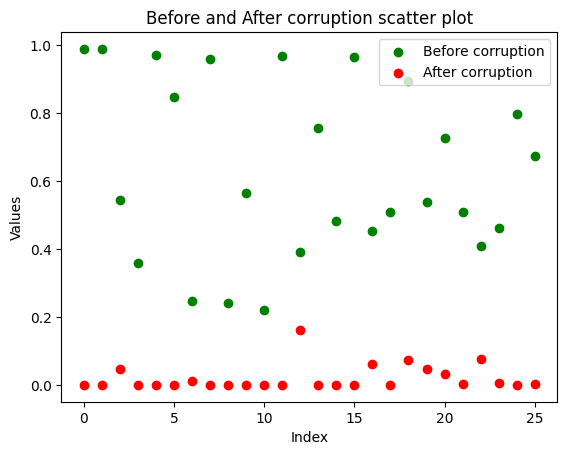

In [4]:
import matplotlib.pyplot as plt

# Data from your list
data = """
0.9866069555282593 7.969379657879472e-05
0.4732622802257538 0.00688205985352397
0.9879531264305115 0.00018526994972489774
0.7379751205444336 0.0010702613508328795
0.5430764555931091 0.04721590504050255
0.9797723293304443 0.001125798444263637
0.35983461141586304 0.000362472579581663
0.2140263170003891 0.014984316192567348
0.9691335558891296 1.388391865475569e-05
0.708112359046936 0.0006585358059965074
0.8476535081863403 3.3349311706842855e-05
0.5361671447753906 9.385454404764459e-07
0.24803784489631653 0.012952195480465889
0.8069132566452026 0.0003555658913683146
0.9587907791137695 0.0009526228532195091
0.9660929441452026 0.0017593996599316597
0.24187912046909332 2.646708935571951e-06
0.5945375561714172 0.00440006610006094
0.5642836689949036 0.0004170921165496111
0.9671798348426819 3.363762516528368e-05
0.21954922378063202 0.000217923239688389
0.9468092918395996 0.0077264816500246525
0.9674734473228455 0.00016668644093442708
0.8169605135917664 0.0011316349264234304
0.39058569073677063 0.16025352478027344
0.6864497661590576 0.001904751523397863
0.7552317976951599 4.193380391370738e-06
0.9735480546951294 0.0012243519304320216
0.48164036870002747 0.0007621957338415086
0.25989866256713867 0.0340917594730854
0.9633808732032776 2.301134736626409e-05
0.9042828679084778 0.0005216260906308889
0.4512379467487335 0.06297965347766876
0.9933866858482361 0.0008901452529244125
0.5083252787590027 5.261739488560124e-07
0.9712671637535095 0.050230395048856735
0.8922507762908936 0.07366945594549179
0.5891431570053101 9.369391591462772e-06
0.5369146466255188 0.047776129096746445
0.9573385119438171 0.015655135735869408
0.7260503768920898 0.03357398137450218
0.9661385416984558 0.0035448558628559113
0.5084898471832275 0.0012985465582460165
0.9808608889579773 0.0001786233187885955
0.4094831049442291 0.07706622779369354
0.24202892184257507 0.10077019780874252
0.4610254168510437 0.004405356477946043
0.7778217792510986 0.0005928561440669
0.7973071932792664 0.0003573252761270851
0.8900036215782166 0.0012839752016589046
0.6745298504829407 0.0017677907599136233
"""

# Convert the string data into a list of pairs of floats
lines = data.strip().split('\n')
list1 = []
list2 = []

for i in range(0, len(lines), 2):
    list1.append(float(lines[i].split()[0]))
    list2.append(float(lines[i].split()[1]))

# Scatter plot
plt.scatter(range(len(list1)), list1, color='green', label='Before corruption')
plt.scatter(range(len(list2)), list2, color='red', label='After corruption')
plt.xlabel('Index')
plt.ylabel('Values')
plt.title('Before and After corruption scatter plot for counterfactual RAG')
plt.legend()
plt.show()


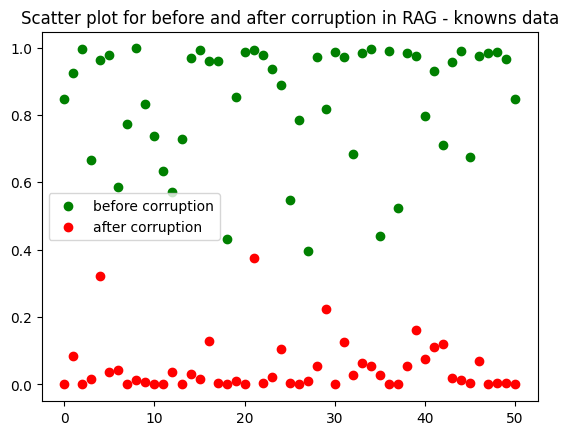

In [9]:
import matplotlib.pyplot as plt

# Given data
data = """
0.8467361330986023 1.991750878005405e-06
0.9233982563018799 0.08526185899972916
0.9955139756202698 0.00011905135033885017
0.6672555804252625 0.016246676445007324
0.9640746116638184 0.32105064392089844
0.9767480492591858 0.03673586994409561
0.5865679979324341 0.04279530793428421
0.7720066905021667 0.0027021400164812803
0.9971508383750916 0.01261222641915083
0.833116888999939 0.007202466018497944
0.7375316619873047 0.00011809646821347997
0.6344130635261536 7.151112981773622e-07
0.57122403383255 0.03830721601843834
0.7283480763435364 5.966322714812122e-05
0.9687817096710205 0.031039157882332802
0.992501974105835 0.014789042063057423
0.9604940414428711 0.12889501452445984
0.9588618874549866 0.0047570387832820415
0.43039947748184204 0.00042327967821620405
0.8527289032936096 0.010344317182898521
0.986227810382843 0.000272219767794013
0.9925681352615356 0.3744414746761322
0.9765135645866394 0.00427336385473609
0.9363675713539124 0.023652995005249977
0.8875800967216492 0.10466887056827545
0.5461442470550537 0.0031496684532612562
0.7857562303543091 0.0003492330142762512
0.3947739601135254 0.011310967616736889
0.9732311367988586 0.05415726825594902
0.8167139887809753 0.22499719262123108
0.9875786900520325 6.284496976149967e-06
0.9704923629760742 0.12464257329702377
0.6831072568893433 0.02936590276658535
0.9831761121749878 0.06349567323923111
0.9953244924545288 0.05562729388475418
0.4414844810962677 0.02793184481561184
0.9890928268432617 0.00031855222187004983
0.5230159163475037 0.00041111442260444164
0.9833664894104004 0.05487748607993126
0.9752951264381409 0.16266663372516632
0.7956327199935913 0.07598939538002014
0.9306607246398926 0.11191679537296295
0.709438681602478 0.11893528699874878
0.9563567638397217 0.017920872196555138
0.9894819259643555 0.01324319839477539
0.6744629144668579 0.004019498825073242
0.9761465191841125 0.07094071060419083
0.982337474822998 0.0015452743973582983
0.9859986305236816 0.004179246723651886
0.9660666584968567 0.004913886543363333
0.8479811549186707 0.0009469115175306797
"""

# Step 1: Extract pairs
pairs = data.strip().split('\n')

# Step 2: Initialize each pair into lists
before_corruption = []
after_corruption = []

for pair in pairs:
    before, after = map(float, pair.split())
    before_corruption.append(before)
    after_corruption.append(after)

# Step 3: Plotting the pairs using matplotlib
plt.scatter(range(len(before_corruption)), before_corruption, color='green', label='before corruption')
plt.scatter(range(len(after_corruption)), after_corruption, color='red', label='after corruption')

# Title and legend
plt.title('Scatter plot for before and after corruption in RAG - knowns data')
plt.legend()

# Display the plot
plt.show()


In [3]:
import os 

arch = "llama"

knowns_ids_1 = os.listdir(f"../results-rerun/{arch}_knowns/pdfs/")
knowns_ids_1 = [k.split("_")[1] for k in knowns_ids_1]

knowns_ids_2 = os.listdir(f"../results-rerun-vanilla/{arch}_vanilla/pdfs/")
knowns_ids_2 = [k.split("_")[1] for k in knowns_ids_2]

import pickle

knowns_ids = set(knowns_ids_1) & set(knowns_ids_2)
print(len(knowns_ids))

pickle.dump(knowns_ids, open(f"known_ids_{arch}.pkl", "wb"))

45


In [41]:
knowns_ids_2 = os.listdir("../results-rerun-vanilla/phi_vanilla/pdfs/")
knowns_ids_2 = [k.split("_")[1] for k in knowns_ids_2]

In [42]:
knowns_ids1 = list(set(knowns_ids_1))

In [43]:
llama_knowns = knowns_ids_1

In [44]:
import pickle
pickle.dump(llama_knowns, open("known_ids_phi.pkl", "wb"))

In [45]:
len(set(knowns_ids_1) & set(knowns_ids_2))

50

In [46]:
len(set(knowns_ids1) ^ (set(knowns_ids_2)))

11